In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from mltools import ld, draw, MachineLearning

In [ ]:
train_iter, val_iter, test_iter = ld.mnist('../data', batch_size=1000)  # 获取训练集、验证集和测试集
# 设置模型结构
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256), nn.ReLU(),
    nn.Linear(256, 10))
device = torch.device('cuda')  # 设置设备


class MLPMachineLearning(MachineLearning):
    def show_pred(self, contents, preds, reals):
        labels = [f'real:{reals[index]}\npred:{preds[index]}' for index in range(len(reals))]
        draw.images(contents.squeeze(1), labels, shape=(2, 5))


ml = MLPMachineLearning(model, train_iter, val_iter, test_iter, device=device)
model_path = '../model/MLP.pth'

train loss 0.243, val loss 0.248, val acc 0.930
5.8 sec/epoch on cuda


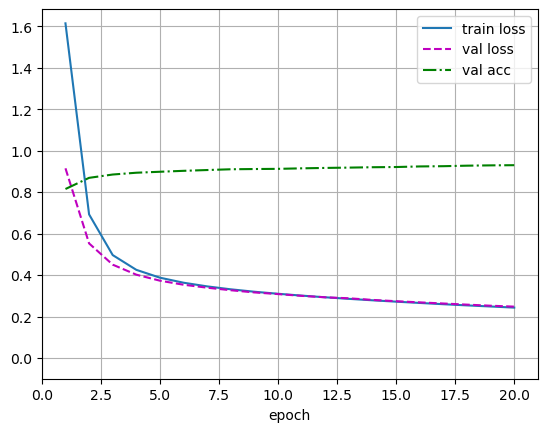

In [3]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1e-1))
if True:
    ml.train(num_epochs=20)  # 训练
    if True:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [4]:
ml.test()  # 测试

Accuracy rate 0.9345


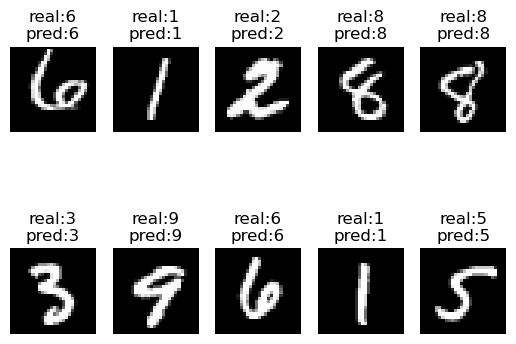

In [5]:
ml.predict()  # 预测